# k Nearest Neighbours

In this notebook, we utilise the kNN classifier to determine whether the provided CT scans of lungs are infected with pneumonia. 

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import argparse
import pathlib
import os
import jwt
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa


def image_to_feature_vector(image, size=(64, 64)):
    """
    Resize all images to be the same size
    """
    return cv2.resize(image, size).flatten()


def get_image_paths(rootPath):
    """
    Get all image paths from root
    """
    imagePaths = []
    for file in os.listdir(rootPath):
        if(file[0] == '.'): continue
        for f in os.listdir(rootPath+file):
            if(f[0] == '.'): continue
            imagePaths.append(os.path.abspath(rootPath+'/'+file+'/'+f))

    return imagePaths

def extract_color_histogram(image, bins=(8, 8, 8)):
    """
    extract a 3D color histogram from the HSV color space using
    the supplied number of `bins` per channel
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    # return the flattened histogram as the feature vector
    return hist.flatten()


"""
The following code will get all images, their corresponding label, and save some as raw images, and others 
as histograms. Both are divided into individual training and testing data
"""
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

all_images = get_image_paths('../dataset/train/')


rawImages = []
features = []
labels = []
files = []

for (i, imagePath) in enumerate(all_images):
    label = imagePath.split(os.path.sep)[-2]
    file = imagePath.split(os.path.sep)[-1]
    image = cv2.imread(imagePath) #sets image to BGR
    images_aug = seq.augment_image(image)
    pixels = image_to_feature_vector(images_aug)
    hist = extract_color_histogram(images_aug)    
    rawImages.append(pixels)
    features.append(hist)

    labels.append(label)
    files.append(file)

    
    if i > 0 and i % 500 == 0:
        print("[INFO] processed {}/{}".format(i, len(all_images)))


rawImages = np.array(rawImages)
features = np.array(features)
labels = np.array(labels)
print("[INFO] pixels matrix: {:.2f}MB".format(
	rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(
	features.nbytes / (1024 * 1000.0)))

(trainRI, testRI, trainRL, testRL) = train_test_split(
	rawImages, labels, test_size=0.25, random_state=42)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
	features, labels, test_size=0.25, random_state=42)



[INFO] processed 500/5216
[INFO] processed 1000/5216
[INFO] processed 1500/5216
[INFO] processed 2000/5216
[INFO] processed 2500/5216
[INFO] processed 3000/5216
[INFO] processed 3500/5216
[INFO] processed 4000/5216
[INFO] processed 4500/5216
[INFO] processed 5000/5216
[INFO] pixels matrix: 62.59MB
[INFO] features matrix: 10.43MB


Text(0, 0.5, 'Mean accuracy scores')

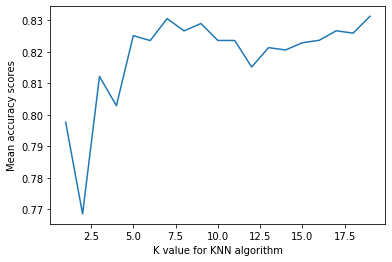

In [4]:
"""
The following fits the kNN classifier and runs a cross_val_score to 
determine the accuracy for k values up to 20.

The results were then applied to improve our algorithm
"""

k_scores = []
k_range = range(1,20)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(trainFeat, trainLabels)
    scores = cross_val_score(knn, testFeat, testLabels, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
    
%matplotlib inline
plt.plot(k_range, k_scores)
plt.xlabel('K value for KNN algorithm')
plt.ylabel('Mean accuracy scores')


In [5]:
"""
Create two models to compare the accuracies between
using raw images and histograms
"""

# train and evaluate a k-NN classifer on the raw pixel intensities
print("[INFO] evaluating raw pixel accuracy...")
ri_model = KNeighborsClassifier(n_neighbors=8)
ri_model.fit(trainRI, trainRL)
ri_acc = ri_model.score(testRI, testRL)
print("[INFO] raw pixel accuracy: {:.2f}%".format(ri_acc * 100))

# train and evaluate a k-NN classifer on the histogram
# representations
print("[INFO] evaluating histogram accuracy...")
fea_model = KNeighborsClassifier(n_neighbors=8)
fea_model.fit(trainFeat, trainLabels)
fea_acc = fea_model.score(testFeat, testLabels)
print("[INFO] histogram accuracy: {:.2f}%".format(fea_acc * 100))

[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 92.18%
[INFO] evaluating histogram accuracy...
[INFO] histogram accuracy: 84.13%


### Confusion Matrix
This matrix shows the quantity of true positives/negatives and false positives/negatives for all classes provided to the classifier

In [12]:
cm = metrics.confusion_matrix(testRL, ri_model.predict(testRI))
data = {
    "Normal": [cm[0][0], cm[1][0]],
    "Pneumonia": [cm[0][1], cm[1][1]]
}
df = pd.DataFrame(data, index=["Normal", "Pneumonia"])
print(df)

           Normal  Pneumonia
Normal        271         86
Pneumonia      16        931


In [11]:
from sklearn import metrics
import pandas as pd

cm = metrics.confusion_matrix(testLabels, fea_model.predict(testFeat))
data = {
    "Normal": [cm[0][0], cm[1][0]],
    "Pneumonia": [cm[0][1], cm[1][1]]
}
df = pd.DataFrame(data, index=["Normal", "Pneumonia"])
print(df)
print("\n")
print(metrics.classification_report(testLabels, fea_model.predict(testFeat)))
print("\n")
print(metrics.classification_report(testRL, ri_model.predict(testRI)))

           Normal  Pneumonia
Normal        262         95
Pneumonia     112        835


              precision    recall  f1-score   support

      NORMAL       0.70      0.73      0.72       357
   PNEUMONIA       0.90      0.88      0.89       947

    accuracy                           0.84      1304
   macro avg       0.80      0.81      0.80      1304
weighted avg       0.84      0.84      0.84      1304



              precision    recall  f1-score   support

      NORMAL       0.94      0.76      0.84       357
   PNEUMONIA       0.92      0.98      0.95       947

    accuracy                           0.92      1304
   macro avg       0.93      0.87      0.89      1304
weighted avg       0.92      0.92      0.92      1304



In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

y_pred_keras = fea_model.predict(testFeat).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testLabels, trainLabels[:1304])

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

/Users/ryanheadley/opt/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:2339: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


ValueError: Data is not binary and pos_label is not specified

### Results

The following results have been accumulated throughout several runs to optimize our algorithm.

<div style="display:block;margin-top:20px;">
<table style="display:inline-block">
    <tr>
        <td>Run 1</td>
        <td>Normal</td>
        <td>Pneumonia</td>
    </tr>
    <tr>
        <td>Normal</td>
        <td>234</td>
        <td>123</td>
    </tr>
    <tr>
        <td>Pneumonia</td>
        <td>116</td>
        <td>831</td>
    </tr>
</table>
    <table style="display:inline-block">
    <tr>
        <td>Run 4</td>
        <td>Normal</td>
        <td>Pneumonia</td>
    </tr>
    <tr>
        <td>Normal</td>
        <td>268</td>
        <td>111</td>
    </tr>
    <tr>
        <td>Pneumonia</td>
        <td>89</td>
        <td>836</td>
    </tr>
</table>
</div>
<table style="display:inline-block">
    <tr>
        <td>Run #</td>
        <td>k</td>
        <td>Raw Pixel Acc</td>
        <td>Histogram Acc</td>
    </tr>
    <tr>
        <td>1</td>
        <td>3</td>
        <td>91.03%</td>
        <td>83.28%</td>
    </tr>
    <tr>
        <td>2</td>
        <td>1</td>
        <td>90.95%</td>
        <td>81.67%</td>
    </tr>
    <tr>
        <td>3</td>
        <td>7</td>
        <td>91.18%</td>
        <td>84.28%</td>
    </tr>
    <tr>
        <td>4</td>
        <td>9</td>
        <td>90.72%</td>
        <td>83.66%</td>
    </tr>
</table>

In [ ]:
import plotly.express as px

"""
Plot the prediction probabilites of the test data to gain
a visual of the data
"""
def plot_spread():
#     y_score = ri_model.predict_proba(testRI)[:, 1]
    y_score = fea_model.predict_proba(testFeat)[:, 1]

    fig = px.scatter(
        testFeat, x=0, y=1,
        color=y_score, color_continuous_scale='RdBu',
        symbol=testLabels, symbol_map={'0': 'square-dot', '1': 'circle-dot'},
        labels={'symbol': 'label', 'color': 'score of <br>first class'}
    )
    fig.update_traces(marker_size=12, marker_line_width=1.5)
    fig.update_layout(legend_orientation='h')
    fig.show()

print(features.shape)
print(labels.shape)

plot_spread()